In [1]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import cartopy.io.img_tiles as cimgt
import pandas as pd
import numpy
import numpy as np
import scipy
from scipy import ndimage, interpolate
import os
import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

from boto.s3.connection import S3Connection
import tempfile

import datetime
from copy import deepcopy

import pyart
%matplotlib inline

from datetime import datetime
import tempfile

from boto.s3.connection import S3Connection
import cartopy
from netCDF4 import num2date
import netCDF4
import xarray
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import ds


from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import shutil

from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [7]:
#FETCH SCRIPT

#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar
# plot a scale bar with 4 subdivisions on the left side of the map
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                  fs=None, oset=2000):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = 'yellow'
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == 'yellow':
            barcol = 'blue'
        else:
            barcol = 'yellow'
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby + oset, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col, fontsize=fs)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby + oset , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col, fontsize=fs)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
            verticalalignment='bottom', color=col, fontsize=fs)

def get_texture(radar, nyq=None):
    """ Calculates velocity texture field. """
    if nyq is None:
        nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
    else:
        nyq = nyq
    std_dev = pyart.util.angular_texture_2d(radar.fields['velocity']['data'],
                                            4, nyq)
    filtered_data = ndimage.filters.median_filter(std_dev, size=(4, 4))
    texture_field = pyart.config.get_metadata('velocity')
    texture_field['data'] = filtered_data
    return texture_field

def namefilter(dframe, radius):
    proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
    point_locs = proj.transform_points(ccrs.PlateCarree(), dframe['Longitude'].values, dframe['Latitude'].values)
    indexes_dc = reduce_point_density(point_locs, radius)
    ndframe = dframe[indexes_dc]
    return ndframe

def plot_points_from_df(dframe, sym='r*', ssize=12, label=None):
    iamfirst = True
    for index, row in dframe.iterrows():
        if iamfirst:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize, label=label)
            iamfirst = False
        else:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize)

#https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM
def plot_text(dframe, dx=0.01, dy=0.01, tcol='c', fontsize=20):
    for index, row in dframe.iterrows():
        plt.text(row['Longitude']+dx, row['Latitude']+dy, row['SiteName'],transform=ccrs.PlateCarree(),
                fontsize=fontsize, color=tcol, alpha=1, weight='bold')
    
wx_code_map = {'': 0, 'DU':7, 'BLDU':7, 'HZ': 5, 'BR': 10, '-UP':16, 'UP': 16, 'SQ': 18, 'FC': 19,
               'DRSN': 36, 'FG': 45, 'FZFG': 49, '-DZ': 51, 'DZ': 53, '+DZ': 55,
               '-RA': 61, 'RA': 63, '+RA': 65, '-FZRA': 66,
               '-SN': 71, 'SN': 73, '+SN': 75, '-SHRA': 80, 'SHRA': 81, '-SHSN': 85, '+TSRA' : 97,
              'TSRA' : 95, '-TSRA' : 95}
def to_code(text):
    for s in text:
        if ' ' in s:
            yield max(to_code(s.split()))
        else:
            yield wx_code_map[s]


def make_sgp_df():
    sgp_df = pd.read_excel('/home/amedendorp/Desktop/All Sites Lats Longs, and distance from CF. More Accurate[1].xlsx')
    sgp_ef_unformatted = sgp_df[1:18]
    sgp_if_unformatted = sgp_df[22:32]

    select_idx = ['IF4-Billings, OK', 'IF5-Garber, OK',
                 'IF6-Deer Creek, OK', 'E13 - Central Facility',
                 'IF8-Tonkawa, OK']

    sgp_select_unformatted = sgp_df[sgp_df['EF LOCATION INFORMATION-More Accurate'].isin(select_idx)]

    sgp_select = pd.DataFrame({'SiteName' : sgp_select_unformatted['EF LOCATION INFORMATION-More Accurate'],
                          'Latitude' : sgp_select_unformatted['Unnamed: 2'],
                          'Longitude' : sgp_select_unformatted['Unnamed: 3']})

    sgp_ef = pd.DataFrame({'SiteName' : sgp_ef_unformatted['EF LOCATION INFORMATION-More Accurate'],
                          'Latitude' : sgp_ef_unformatted['Unnamed: 2'],
                          'Longitude' : sgp_ef_unformatted['Unnamed: 3']})

    sgp_if = pd.DataFrame({'SiteName' : sgp_if_unformatted['EF LOCATION INFORMATION-More Accurate'],
                          'Latitude' : sgp_if_unformatted['Unnamed: 2'],
                          'Longitude' : sgp_if_unformatted['Unnamed: 3']})
    return sgp_select, sgp_if, sgp_ef


def get_obs(ts, mybb):
    # copied from the browser url box
    metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
    # parse the xml
    metar_cat = TDSCatalog(metar_cat_url)
    # what datasets are here? only one "dataset" in this catalog
    dataset = list(metar_cat.datasets.values())[0]
    ncss_url = dataset.access_urls["NetcdfSubset"]
    ncss = NCSS(ncss_url)

    query = ncss.query().accept('csv').time(ts)
    query.lonlat_box(**mybb)
    query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                    'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')
    data = ncss.get_data(query)

    try:
        lats = data['latitude'][:]
        lons = data['longitude'][:]
        tair = data['air_temperature'][:]
        dewp = data['dew_point_temperature'][:]
        slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

        # Convert wind to components
        u, v = mpcalc.get_wind_components(data['wind_speed'] * units.knot,
                                          data['wind_from_direction'] * units.deg)

        # Need to handle missing (NaN) and convert to proper code
        cloud_cover = 8 * data['cloud_area_fraction']
        cloud_cover[np.isnan(cloud_cover)] = 9
        cloud_cover = cloud_cover.astype(np.int)

        # For some reason these come back as bytes instead of strings
        stid = [s.decode() for s in data['station']]



        # Convert the text weather observations to WMO codes we can map to symbols
        if data['weather'].dtype != bool:
            wx_text = [s.decode('ascii') for s in data['weather']]
            wx_codes = np.array(list(to_code(wx_text)))
        else:
            wx_codes = np.array([0]*len(data['weather']))

        sfc_data = {'latitude': lats, 'longitude': lons,
                    'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
                    'northward_wind': v, 'cloud_coverage': cloud_cover,
                    'air_pressure_at_sea_level': slp, 'present_weather': wx_codes}

        have_obs = True
    except IndexError:
        have_obs = False
        sfc_data={}
    
    return sfc_data, have_obs


def plot_the_ppi(radar, ex, sgp_select, sgp_if, sgp_ef, have_obs, sfc_data,
                d, rname, gatefilter=None, moment='reflectivity', vmin=-8,
                vmax=64, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, sweep=0,
                form='.png'):
    mybb = {'north' : ex[3], 'south': ex[2], 'east' : ex[0], 'west' : ex[1]}
    myf = plt.figure(figsize=[20,18])
    proj = ccrs.PlateCarree()
    mydisplay = pyart.graph.RadarMapDisplayCartopy(radar)
    mydisplay.plot_ppi_map(moment, sweep=sweep, 
                           cmap=cmap,
                          embelish=False, vmin=vmin, vmax=vmax,
                          min_lat=mybb['south'], max_lat=mybb['north'],
                          min_lon=mybb['west'], max_lon=mybb['east'],
                          projection = proj,
                          gatefilter=gatefilter)

    ax = plt.gca()


    ax.set_extent(ex)


    lat_lines = np.arange(np.around(ex[2], decimals=1), 
                          ex[3], .2)
    lon_lines = np.arange(np.around(ex[0],decimals=1),
                          ex[1], .5)

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='gray')




    request = cimgt.StamenTerrain()
    if True:#len(request.imgs) > 0:
        ax.add_image(request, 10, zorder=0)



    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--',
                     xlocs=lon_lines, ylocs=lat_lines)

    scale_bar_left(plt.gca(), linewidth=12, fs=25, col='Black', length=50)

    plot_points_from_df(sgp_ef, sym='r*', ssize=12, label='Extended Facilities')
    plot_points_from_df(sgp_if, sym='b*', ssize=12, label='Intermediate Facilities')
    plot_text(sgp_select, dx=0.01, dy=0.01, tcol='k', fontsize=14)

    if have_obs:
        stationplot = StationPlot(ax, sfc_data['longitude'], sfc_data['latitude'],
                                  transform=ccrs.PlateCarree(),
                                  fontsize=12)
        simple_layout.plot(stationplot, sfc_data)


    ax.set_aspect(1.1)
    plt.savefig('/home/amedendorp/SULI projects/images/'+rname+'_'+d+'_'+ moment +'_.png')



def get_cf_loc(radar, sgp_select):
    synppi = pyart.util.cross_section_rhi(radar, [0.5])

    cf_lat = sgp_select['Latitude'][4]
    cf_lon = sgp_select['Longitude'][4]
    print(cf_lat)
    lats = synppi.gate_latitude['data']
    lons = synppi.gate_longitude['data']

    a = abs(lats-cf_lat)+abs(lons-cf_lon)
    i,j = np.unravel_index(a.argmin(),a.shape)

    cf_range = radar.range['data'][j]
    cf_sweep = i
    return cf_sweep, cf_range/1000.0



def get_i8_loc(radar, sgp_select):
    synppi = pyart.util.cross_section_rhi(radar, [0.5])

    i8_lat = sgp_select['Latitude'][26]
    i8_lon = sgp_select['Longitude'][26]
    print(i8_lat)
    lats = synppi.gate_latitude['data']
    lons = synppi.gate_longitude['data']

    a = abs(lats - i8_lat) + abs(lons - i8_lon)
    i,j = np.unravel_index(a.argmin(),a.shape)

    i8_range = radar.range['data'][j]
    sweep = i
    return sweep, i8_range/1000.0

def plot_the_rhi(radar, rname, d, sweep=None, moment='reflectivity', vmin=-8,
                vmax=64, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, sgp_select=None,
                form='.png'):
    
    if sweep is None:
        sweep, i8_range = get_i8_loc(radar, sgp_select)
        print(sweep, i8_range)
        plot_i8 = True
    
    myf = plt.figure(figsize=[20,8])
    mydisplay = pyart.graph.RadarDisplay(radar)
    mydisplay.plot_rhi(moment, sweep=sweep, 
                           cmap=cmap,
                       vmin=vmin, vmax=vmax)
    plt.ylim([0,16])
    plt.xlim([0,60])
    if plot_i8:
        plt.gca().annotate('IF8-Tonkawa, OK', xy=(i8_range, 0.1), xytext=(i8_range+5, 1.5),
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    plt.savefig('/home/amedendorp/SULI projects/images/'+rname+'_'+d+'_RHI_'+moment+form) 
    

In [8]:
#PULLING RADAR DATA
radar_targ = 'ARM'


In [9]:
#IDENTIFYING THE SEPARATE RADAR FILES
if radar_targ == 'ARM':
    radar_file = '/home/amedendorp/Desktop/XSE180531060012.RAWFLUS'
    radar = pyart.io.read(radar_file)

    dateobj = np.datetime64(radar.time['units'][14:])
    ts = pd.to_datetime(str(dateobj)) 
    d = ts.strftime('%Y%m%d_%H%M')
    rname = radar_file.split('/')[-1][0:3]
elif radar_targ == 'NEXRAD':
    station = 'KVNX'
    my_datetime = datetime.datetime.utcnow()
    radar = get_radar_from_aws(station, my_datetime)
    dateobj = np.datetime64(radar.time['units'][14:])
    ts = pd.to_datetime(str(dateobj)) 
    d = ts.strftime('%Y%m%d_%H%M')
    rname = 'KVNX'
elif radar_targ == 'NEXRADARM':
    radar_file = '/home/amedendorp/Desktop/XSW180531061505.RAW046A'
    radar = pyart.io.read(radar_file)
    dateobj = np.datetime64(radar.time['units'][14:])
    ts = pd.to_datetime(str(dateobj))
    station = 'KVNX'
    my_datetime = ts
    radar = get_radar_from_aws(station, my_datetime)
    dateobj = np.datetime64(radar.time['units'][14:])
    ts = pd.to_datetime(str(dateobj)) 
    d = ts.strftime('%Y%m%d_%H%M')
    rname = 'KVNX'
    
    

/home/amedendorp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


36.708631
5 30.4


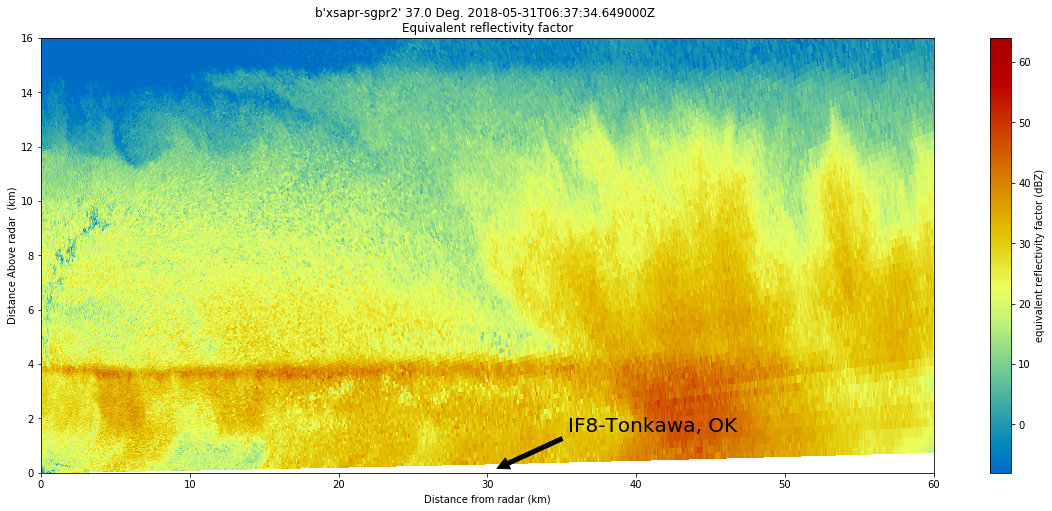

In [10]:
#PLOTTING THE FIRST RADAR, AN RHI FILE
radar1 = pyart.io.read('/data/suli_data/xsapr/XSW180531063505.RAW046E')
if radar1.scan_type == 'rhi':
    sgp_select, sgp_if, sgp_ef = make_sgp_df()
    plot_the_rhi(radar1, rname, d, sgp_select=sgp_select)
else:
    ex = [-98.2, -96.9, 36.1, 37.1]#[-98.7, -96.5, 35.6, 37.4]
    mybb = {'north' : ex[3], 'south': ex[2], 'east' : ex[0], 'west' : ex[1]}
    sgp_select, sgp_if, sgp_ef = make_sgp_df()
    sfc_data, have_obs = get_obs(ts, mybb)
    plot_the_ppi(radar1, ex, sgp_select, sgp_if, sgp_ef, have_obs, sfc_data,
                d, rname)
    
    

In [11]:
#PLOTTING RADAR 2, A PPI
radar2 = pyart.io.read('/data/suli_data/xsapr/XNW180531063508.RAWU5DW')

ex = [-98.2, -96.9, 36.1, 37.1]#[-98.7, -96.5, 35.6, 37.4]
mybb = {'north' : ex[3], 'south': ex[2], 'east' : ex[0], 'west' : ex[1]}
sgp_select, sgp_if, sgp_ef = make_sgp_df()
sfc_data, have_obs = get_obs(ts, mybb)
plot_the_ppi(radar1, ex, sgp_select, sgp_if, sgp_ef, have_obs, sfc_data,
            d, rname)


KeyError: 'content-type'

In [ ]:
#PLOTTING RADAR 3, A PPI
radar3 = pyart.io.read('/data/suli_data/xsapr/XSE180531062018.RAWFLUW')
ex = [-98.2, -96.9, 36.1, 37.1]#[-98.7, -96.5, 35.6, 37.4]
mybb = {'north' : ex[3], 'south': ex[2], 'east' : ex[0], 'west' : ex[1]}
sgp_select, sgp_if, sgp_ef = make_sgp_df()
sfc_data, have_obs = get_obs(ts, mybb)

plot_the_ppi(radar3, ex, sgp_select, sgp_if, sgp_ef, have_obs, sfc_data,
                d, rname)


In [ ]:
#GRIDDING THE 3 RADAR FILES TOGETHER
grids = pyart.map.grid_from_radars((radar1, radar2, radar3),(50,801,801),
                   ((1000.,10001.),(-70000.,70000.),(-70000.,70000.)),
                   grid_origin=(36.604937, -97.485561), fields=['reflectivity'],
                   refl_field='reflectivity', minimum_roi=100, weighting_function = 'Cressman', 
                   roi_funct=(0, 98, 37),rid_origin_alt=None, grid_projection=None, 
                   gatefilters=False, toa=17000.0, roi_func='dist_beam', constant_roi=500.0,
                   z_factor=0.05, xy_factor=0.02, min_radius=300.0, h_factor=1.0, nb=1.5, bsp=1.0, )


In [ ]:
#TURNING THE GRID INTO AN X-ARRAY IN ORDER TO PLOT RADAR LOCATIONS
lon, lat = grids.get_point_longitude_latitude()
height = grids.point_z['data'][:,0,0]
time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])


ds = xarray.Dataset()
for this_field in list(grids.fields.keys()):
    this_data = grids.fields[this_field]['data']
    this_data = np.ma.filled(this_data, np.nan)
    my_data = xarray.DataArray(np.expand_dims(this_data,0),
                               dims = ('time', 'z', 'y', 'x'),
                               coords = {'time' : (['time'], time),
                                         'z' : (['z'], height),
                                         'lat' :(['y','x'], lat),
                                         'lon' : (['y','x'],lon),
                                          'y' : (['y'],lat[:,0]),
                                          'x' : (['x'],lon[0,:])})
    
    for this_meta in list(grids.fields[this_field].keys()):
        if this_meta is not 'data':
            my_data.attrs.update({this_meta: grids.fields[this_field][this_meta]})
    
    ds[this_field] = my_data
    ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
             ('units', 'degrees_east')]
    ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
             ('units', 'degrees_north')]
    ds.z.attrs['long_name'] = "height above sea sea level"
    ds.z.attrs['units'] = "m"

    ds.z.encoding['_FillValue'] = -9999.0
    ds.lat.encoding['_FillValue'] = -9999.0
    ds.lon.encoding['_FillValue'] = -9999.0
    

In [ ]:
#PLOTTING THE X-ARRAY WITH RADAR LOCATIONS
fig = plt.figure(figsize=[30, 10])
ref = ds.reflectivity
my_ax = plt.subplot(projection = ccrs.PlateCarree())

pc = ds.reflectivity[0].sel(z=500, method='nearest').plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=0,
                                                    vmax=70, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)


lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), 
                      ds.lat.max(), .2)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1),
                      ds.lon.max(), .5)
my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)


gl = my_ax.gridlines(draw_labels=False,
                              linewidth=1, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

my_ax.set_aspect(1.15)

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)

al = my_ax.gridlines(draw_labels=False,
                 linewidth=1, linestyle="--", edgecolor="red")

IF4_Billings_lon, IF4_Billings_lat = -97.363834, 36.57865
IF5_Garber_lon, IF5_Garber_lat = -97.593936, 36.491178
IF6_Deer_Creek_lon, IF6_Deer_Creek_lat = -97.547446, 36.767569
Nardin_lon, Nardin_lat = -97.449012, 36.796101
IF8_Tonkawa_lon, IF8_Tonkawa_lat = -97.386319, 36.708631
billings_lon, billings_lat = -97.421082, 36.477116
Lamont_lon, Lamont_lat = -97.628475, 36.66557
IF11_lon, IF11_lat = -97.5313, 36.6223
IF12_lon, IF12_lat = -97.4894, 36.6517
E13_Central_Facility_lon, E13_Central_Facility_lat = -97.485561, 36.604937


plt.plot([IF4_Billings_lon], [IF4_Billings_lat], color='blue', marker= '*')
plt.plot([IF5_Garber_lon], [IF5_Garber_lat], color='blue', marker= '*')
plt.plot([IF6_Deer_Creek_lon], [IF6_Deer_Creek_lat], color='blue', marker= '*')
plt.plot([Nardin_lon], [Nardin_lat], color='blue', marker= '*')
plt.plot([IF8_Tonkawa_lon], [IF8_Tonkawa_lat], color='blue', marker= '*')
plt.plot([billings_lon], [billings_lat], color='blue', marker= '*')
plt.plot([Lamont_lon], [Lamont_lat], color='blue', marker= '*')
plt.plot([IF11_lon], [IF11_lat], color='blue', marker= '*')
plt.plot([IF12_lon], [IF12_lat], color='blue', marker= '*')
plt.plot([E13_Central_Facility_lon], [E13_Central_Facility_lat], color='red', marker= '*')

plt.text(IF4_Billings_lon + 0.01, IF4_Billings_lat - 0., 'IF4-Billings', horizontalalignment='left')
plt.text(IF5_Garber_lon - 0.01, IF5_Garber_lat - 0, 'IF5-Garber', horizontalalignment='right')
plt.text(IF6_Deer_Creek_lon - 0.01, IF6_Deer_Creek_lat - 0, 'IF6-Deer Creek', horizontalalignment='right')
plt.text(IF8_Tonkawa_lon - 0.01, IF8_Tonkawa_lat + 0.01, 'IF8-Tonkawa', horizontalalignment='left')
plt.text(E13_Central_Facility_lon + 0.07, E13_Central_Facility_lat - 0.03, 'E13-Central Facility', color= 'darkred', horizontalalignment='right')

def cross_hair(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    horiz = ax.axhline(y)
    vert = ax.axvline(x)
    return horiz, vert




font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
my_ax.set_extent(extent)
request = cimgt.GoogleTiles(style='terrain')
my_ax.add_image(request, 10, zorder=0)



In [ ]:
#PLOTTING THE ORIGINAL GRID FILE
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[30, 10])

font = {'size': 11}
matplotlib.rc('font', **font)

# Panel sizes.
map_panel_axes = [0.55, 0.05, .4, .80]
x_cut_panel_axes = [0.05, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]


# Parameters.
level = 0
vmin = 0
vmax = 70
lat = 37
lon = -99

my_ax.set_aspect(1.15)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)



ax1 = fig.add_axes(map_panel_axes)
ax1.set_xticks(np.arange(130, 132, 0.5))
display.plot_basemap(lon_lines = np.arange(-104, -93, 2))
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax,
                  cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
display.plot_crosshairs(lon=-97.44, lat=36.65, linewidth=1)



In [ ]:
#FIRST STEP IN THE EDGE-DETECTION CODE
my_array = grids.fields['reflectivity']['data'][0,:,:]


In [ ]:
#CREATING THE ARRAY OBJECT
scipy_array = scipy.ndimage.sobel(my_array, mode='reflect')
plt.pcolormesh(np.abs(scipy_array), cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
              vmin = 0, vmax = 50)
plt.colorbar()


In [ ]:
#CREATING THE EDGE-DETECTION PLOT
my_ax.set_aspect(.5)
plt.title('XSAPR Edge Detection at 6:35:10', size = '20')
plt.pcolormesh(np.abs(np.ma.masked_array(scipy_array, mask=my_array.mask)), cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
              vmin = 0, vmax = 50)
plt.xlabel('dpixel')
plt.ylabel('dz')
plt.colorbar()


In [ ]:
#CREATING A HISTOGRAM TO PLOT THE AMOUNT OF EDGE-DETECTION OBJECTS IN THE PLOT
is_good = np.logical_not(my_array.mask).flatten()
hist, be =  np.histogram(np.abs(scipy_array.flatten()[is_good]), bins=np.linspace(0,50,10))


In [ ]:
#PLOTTING THE HISTOGRAM
plt.title('XSAPR Edge Detection Histogram at 6:35:10', size = '20')

plt.ylim([0,45000])
plt.xlim([0,45])
plt.xlabel('abs gradient')
plt.ylabel('grid cells')
plt.plot(be[0:-1], hist)
plt.savefig('/home/amedendorp/Desktop/' + 'Edge_Hist_XSAPR', bbox_inches='tight', dpi=300)

In [ ]:
#PLOTTING THE LONGITUDE SLICE FOR THE GRID
fig = plt.figure(figsize=[20, 12])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
display.plot_longitude_slice('reflectivity', lon=-97.44, 
                             cmap=pyart.graph.cm_colorblind.HomeyerRainbow)


In [ ]:
#PLOTTING THE LATITUDE SLICE FOR THE GRID
fig = plt.figure(figsize=[20, 12])

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

display.plot_latitude_slice('reflectivity', lat=36.65,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow)


